#### <u> <font color=blue> Load Packages </font>  </u>

In [39]:
rm(list=ls())
library('Biobase')
library('limma')
library("biomaRt")
library("edgeR")
library('EnhancedVolcano')
library("clusterProfiler")
library("DOSE")
library("tibble")
library("org.Mm.eg.db")
library("enrichplot")
library("GOSemSim")
library("GOplot")

PATH = paste(getwd(), sep = .Platform$file.sep)
PATH_DATA = paste(PATH, 'Data', sep = .Platform$file.sep)
PAPER_DATA = paste(PATH, 'Supplementary', sep = .Platform$file.sep)

createFolder <- function(folder_name) {
  # Check if the folder already exists
  if (!dir.exists(folder_name)) {
    # The folder doesn't exist, so create it
    dir.create(folder_name)
    message(paste("Folder", folder_name, "created successfully."))
  } else {
    # The folder already exists
    message(paste("Folder", folder_name, "already exists."))
  }
}

createFolder('Figures')
createFolder('Supplementary')

Folder Figures already exists.

Folder Supplementary already exists.



#### <u> <font color=blue> Download mouse gene annotations</font>  </u>

In [40]:
# ensembl <- useMart("ensembl", dataset="mmusculus_gene_ensembl")
# annot <- getBM(attributes =  c("ensembl_gene_id", "entrezgene_id", "mgi_symbol", "chromosome_name", "strand", "start_position", "end_position","gene_biotype"),
#                mart=ensembl)

# write.table(annot, paste(PATH_DATA, "Annotations.tsv", sep = .Platform$file.sep)  ,sep="\t",row.names=FALSE)
# dim(annot)


#### <u> <font color=blue> Load gene expression counts</font>  </u>

In [41]:
counts <- read.delim(  paste(PATH_DATA,  "Th2+-VitD", "Th2+-VitD.tsv", sep = .Platform$file.sep) , row.names = 1)
colnames(counts) <- substr(colnames(counts), start = 1, stop = 11)
colnames(counts) <- gsub("\\.","-",colnames(counts))
head(counts)
dim(counts)

samples <- colnames(counts)
nsamples <- length(samples)

,S-001656706,S-001656716,S-001656723,S-001656717,S-001656715,S-001656711,S-001656721,S-001656709,S-001656710,S-001656719,⋯,S-001656714,S-001656703,S-001656724,S-001656705,S-001656702,S-001656718,S-001656720,S-001656707,S-001656708,S-001656713
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000000001,1448,2080,2006,1685,1464,1251,4255,1394,761,1804,⋯,1212,1243,1503,527,1525,2115,2520,1749,1132,1632
ENSMUSG00000000003,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000028,360,644,698,642,456,495,1134,294,285,602,⋯,480,360,432,124,392,672,861,395,262,562
ENSMUSG00000000031,11,28,10,23,10,12,36,19,5,15,⋯,13,6,3,1,6,9,9,10,8,13
ENSMUSG00000000037,3,6,10,4,2,2,9,1,5,5,⋯,2,5,5,1,2,5,8,2,3,6
ENSMUSG00000000049,0,0,0,0,0,1,5,0,1,0,⋯,0,0,0,0,0,0,0,0,1,0


[1] 49671    22

#### <u> <font color=blue>Remove duplicates and subset annotations</font>  </u>

In [42]:
## Remove duplicates in ensembl_gene_id column
annot <- read.csv(file =  paste(PATH_DATA, "Annotations.tsv", sep = .Platform$file.sep), sep = '\t', header = TRUE)

annot <- annot[!duplicated(annot$ensembl_gene_id), ]
rownames(annot) <- annot$ensembl_gene_id
annot <- annot[rownames(counts),]

head(annot)
dim(annot)

,ensembl_gene_id,entrezgene_id,mgi_symbol,chromosome_name,strand,start_position,end_position,gene_biotype
,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<chr>
ENSMUSG00000000001,ENSMUSG00000000001,14679,Gnai3,3,-1,108014596,108053462,protein_coding
ENSMUSG00000000003,ENSMUSG00000000003,54192,Pbsn,X,-1,76881507,76897229,protein_coding
ENSMUSG00000000028,ENSMUSG00000000028,12544,Cdc45,16,-1,18599197,18630737,protein_coding
ENSMUSG00000000031,ENSMUSG00000000031,14955,H19,7,-1,142129262,142131917,lncRNA
ENSMUSG00000000037,ENSMUSG00000000037,107815,Scml2,X,1,159865521,160041209,protein_coding
ENSMUSG00000000049,ENSMUSG00000000049,11818,Apoh,11,1,108234180,108305222,protein_coding


[1] 49671     8

#### <u> <font color=blue> Load meta data </font>  </u>

In [43]:
meta <- read.csv(  paste(PATH_DATA,  "Th2+-VitD", "Th2_metadata.csv", sep = .Platform$file.sep) , row.names=1, sep=';')
meta$condition<-gsub(" ", "_",meta$condition)
meta <- meta[colnames(counts),]
head(meta)
dim(meta)

,genotype,condition
,<chr>,<chr>
S-001656706,WT,control
S-001656716,WT,control
S-001656723,WT,Vitamin_D
S-001656717,WT,control
S-001656715,WT,control
S-001656711,WT,control


[1] 22  2

In [44]:
print(paste('Control: ', dim(meta[meta[,'condition']=='control',])[1]))
print(paste('Vitamin D: ', dim(meta[meta[,'condition']=='Vitamin_D',])[1]))

[1] "Control:  11"
[1] "Vitamin D:  11"


### <u> <font color=blue> Normalize counts data </font>  </u>

In [45]:
x <- DGEList(counts)
dim(x)

[1] 49671    22

In [46]:
## Store meta information in x
x$genes <- annot
samplenames <- rownames(meta)
group <- meta$condition
x$samples$group <- meta$condition

# head(x)

In [47]:
## Convert counts to cpm and log-cpm
cpm <- cpm(x)
lcpm <- cpm(x, log=TRUE)

L <- mean(x$samples$lib.size) * 1e-6
M <- median(x$samples$lib.size) * 1e-6
c(L, M)

#summary(lcpm)

[1] 8.601152 7.504710

In [48]:
## Removing genes with lowly expressed genes
table(rowSums(x$counts==0)==nsamples)


FALSE  TRUE 
27301 22370 

In [49]:
## Larger the library size, lower the CPM cutoff and vice versa
keep.exprs <- filterByExpr(x, group=group)
x <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(x)

[1] 11905    22

Warning message in brewer.pal(nsamples, "Paired"):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”


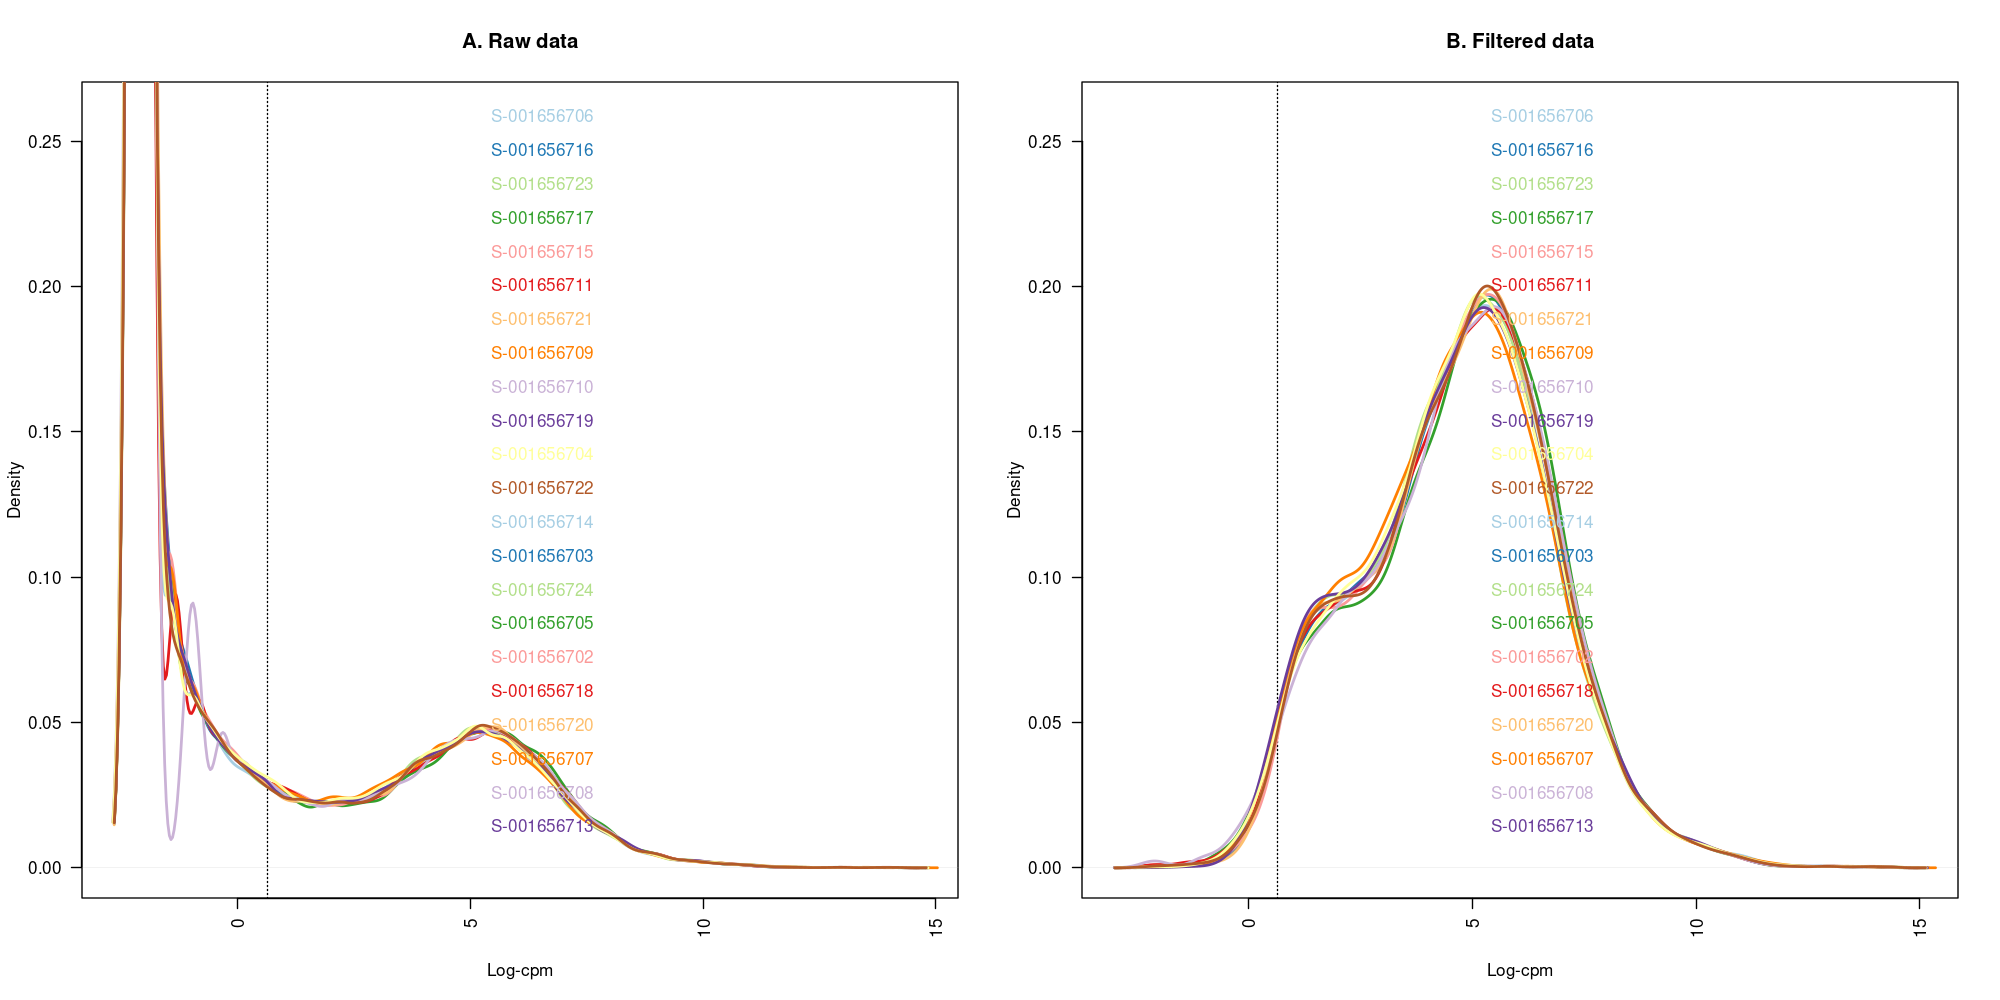

In [50]:
lcpm.cutoff <- log2(10/M + 2/L)
library(RColorBrewer)
nsamples <- ncol(x)
col <- brewer.pal(nsamples, "Paired")
par(mfrow=c(1,2))
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)

for (i in 2:nsamples){
 den <- density(lcpm[,i])
 lines(den$x, den$y, col=col[i], lwd=2)
}


legend("topright", samplenames, text.col=col, bty="n")
lcpm <- cpm(x, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)

for (i in 2:nsamples){
 den <- density(lcpm[,i])
 lines(den$x, den$y, col=col[i], lwd=2)
}

legend("topright", samplenames, text.col=col, bty="n")

In [51]:
## Normalisation is required to ensure that the expression distributions
## of each sample are similar across the entire experiment.
x <- calcNormFactors(x, method = "TMM")
x$samples$norm.factors
dim(x)

[1] 0.9870093 1.0286709 0.9692287 1.0587922 1.0284130 1.0304955 1.0260134
 [8] 0.9456560 1.0382051 0.9820662 0.9717092 1.0224286 0.9796678 1.0278030
[15] 0.9799515 0.9688220 1.0244789 0.9890329 1.0209449 0.9982114 0.9388932
[22] 0.9942145

[1] 11905    22

In [52]:
# x2 <- x
# x2$samples$norm.factors <- 1
# x2$counts[,1] <- ceiling(x2$counts[,1]*0.05)
# x2$counts[,2] <- x2$counts[,2]*5

In [53]:
# lcpm <- cpm(x, log=TRUE)

In [54]:
# plotMDS(lcpm, labels=samplenames, col=col.group)
# title(main="Samples separated on condition")

### <u> <font color=blue> Run Limma </font>  </u>

In [55]:
# meta$condition <- gsub("Vitamin_D","VitaminD",meta$condition)
meta$condition <- gsub("control", "Healthy", meta$condition)
head(meta)

,genotype,condition
,<chr>,<chr>
S-001656706,WT,Healthy
S-001656716,WT,Healthy
S-001656723,WT,Vitamin_D
S-001656717,WT,Healthy
S-001656715,WT,Healthy
S-001656711,WT,Healthy


### <u> <font color=blue> Differential expression analysis </font>  </u>

conditionHealthy conditionVitamin_D 
                11                 11

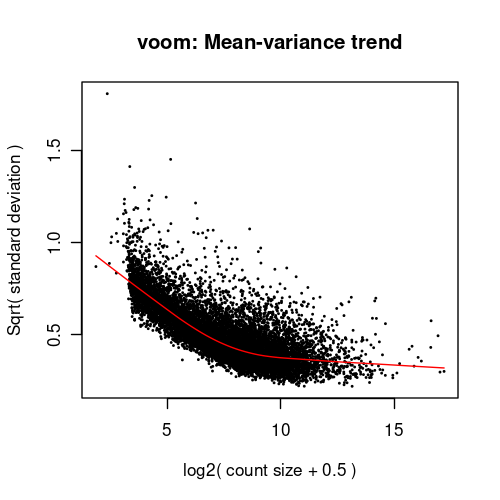

       VitD_stim
Down        1917
NotSig      8061
Up          1927

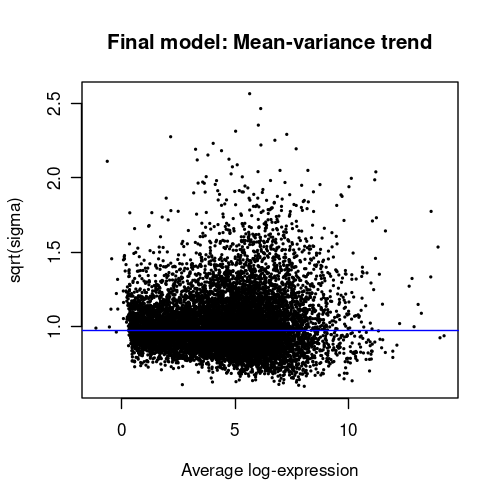

In [56]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 100) 

# Create design matrix with no intercept
design <- model.matrix(~0+condition, data = meta)
# Count the number of samples modeled by each coefficient
colSums(design)

# Create a contrasts matrix
cm <- makeContrasts(VitD_stim = conditionVitamin_D - conditionHealthy,
                    levels = design)

v <- voom(x, design, plot=TRUE)

# Fit the model
fit <- lmFit(v, design)
# Fit the contrasts
fit2 <- contrasts.fit(fit, contrasts = cm)
# Calculate the t-statistics for the contrasts
fit2 <- eBayes(fit2)
plotSA(fit2, main="Final model: Mean-variance trend")

# Summarize results
results <- decideTests(fit2, p.value = 0.05)
summary(results)

In [57]:
### works
res <- topTable(fit2, coef='VitD_stim', number=Inf, sort.by='p', lfc = 0.585, p.value = 0.01)

down_genes = summary(results)['Down','VitD_stim']
up_genes = summary(results)['Up','VitD_stim']

## Differentially expressed genes
de_genes <- head(res, up_genes+down_genes)


fcvals_up <- de_genes[de_genes['logFC'] > 0,]
fcvals_down <- de_genes[de_genes['logFC'] < 0,]
dim(fcvals_up)
dim(fcvals_down)

[1] 470  14

[1] 441  14

In [58]:
file_name = paste(PAPER_DATA, 'Tab_S4.csv', sep = .Platform$file.sep)
write.csv(de_genes[,c('entrezgene_id','mgi_symbol','gene_biotype',
           'logFC','AveExpr','t','P.Value','adj.P.Val','B')],file_name)#, row.names=FALSE)

In [59]:
'Vdr' %in% annot[rownames(fcvals_up) ,]$mgi_symbol
'Vdr' %in% annot[rownames(fcvals_down),]$mgi_symbol

[1] FALSE

[1] TRUE

> Upregulated genes (Vit. D stimuated)

In [60]:
up = sort(annot[as.matrix(annot['ensembl_gene_id']) %in% rownames(fcvals_up), 'mgi_symbol'])
length(up)
cat(up)

[1] 468

1700001L05Rik 1700042O10Rik 1700056N10Rik 1810034E14Rik 1810041H14Rik 2210408F21Rik 2500004C02Rik 2810013P06Rik 2900052L18Rik 3110056K07Rik 4930486L24Rik 4932438H23Rik 4933406C10Rik 4933406I18Rik 4933406J09Rik 5031415H12Rik 5031434O11Rik 5330432J10Rik 9330175E14Rik a A630023P12Rik AB124611 Ablim1 Acat3 Acp3 Acsbg1 Acvr2a Adam19 Adam8 Adamtsl3 Add3 Airn Akap6 Amigo2 Amotl2 Ank Ankrd36 Ankrd55 Antxr2 Aqp11 Aqp9 Areg Arhgap5 Arhgef10l Arid4a Arl4c Arl4d Atg14 Atp2b1 AW011738 B3glct B430306N03Rik Baz1a BC043934 Bcl2l11 Bltp1 Bmp7 C130074G19Rik C230085N15Rik Cacna2d4 Cadm4 Calm1 Car5b Card6 Casp6 Castor1 Cavin3 Cbr1 Ccdc117 Ccdc125 Ccdc92 Ccr1 Ccr2 Ccr5 Cd200r1 Cd200r4 Cd24a Cd86 Cdadc1 Cdc42ep4 Cdcp1 Cdh2 Cdk20 Cebpd Cfp Chst2 Clec2l Cnst Cobll1 Colec12 Cracr2a Creb3l2 Cstdc4 Ctla2a Ctla2b Ctla4 Ctps2 Ctse Ctsf Ctsl Cwh43 Cxcr1 Cyp24a1 Cysltr2 Dap Ddc Dennd2d Dgkg Dhrs3 Dhx57 Disc1 Dixdc1 Dmpk Dnajc28 Dntt Dpp4 Dusp6 E230032D23Rik E330020D12Rik Ecm1 Eeig1 Efna4 Elovl7 Eml1 Enam Enc1 Endod1

> Downregulated genes - WT

In [61]:
down = sort(annot[as.matrix(annot['ensembl_gene_id']) %in% rownames(fcvals_down), 'mgi_symbol'])
length(down)
cat(down)

[1] 438

2310003N18Rik 4632415L05Rik 9930014A18Rik A630001O12Rik Aard Abca1 Abcb1a Abcb1b Ablim2 Acot2 Acot6 Acsl1 Actn1 Acy3 Adamts6 Adora2a Adora2b Afap1 Aff3 Ajuba Akr1c13 Aldh1a3 Aldh1l2 Anxa4 Aqp3 Arhgap31 Arhgdig Arhgef40 Arhgef9 Armcx1 Art2a Atf3 Atf5 Atp10a Atp4a Atrnl1 Avpi1 Axl B4galt4 Batf3 BC064078 Bcl2a1b Bcl2a1d Bcl2l1 Bcl2l14 Bend4 Bhlhe40 Bst1 Bst2 Btla C1ql3 C1qtnf12 C1rl C1s1 C1s2 Cacna1s Cacnb3 Camk2n1 Capn5 Carmil3 Casp1 Casz1 Cavin1 Ccdc136 Ccdc184 Ccdc50 Ccl4 Ccn4 Ccr7 Cd200 Cd226 Cd55 Cd83 Cd9 Cdkl5 Cercam Chml Chn2 Chst11 Clcn2 Clec2i Clstn3 Comtd1 Cptp Crabp2 Csf2 Cth Cttnbp2nl Dapl1 Ddit3 Dgat1 Dgkk Dhcr7 Dhrs13 Dnah12 Dnai4 Dnal1 Dnm1 Dock1 Dpy19l1 Dsp Dusp14 Dusp3 Dusp4 Ebi3 Ece1 Eda2r Ehbp1 Eif2ak2 Eif5a2 Elovl4 Emp3 Entpd2 Ermn Esrp2 Etv4 Extl1 Fam241a Fasl Fcrl2 Fgd6 Fgf11 Fibcd1 Flnb Fn1 Fos Frzb Fyb Fzd7 Gab2 Gadd45b Gadd45g Garin3 Gask1a Gch1 Gfpt2 Glud1 Gm10369 Gm12735 Gm13546 Gm14276 Gm17590 Gm20186 Gm31718 Gm9885 Gnaz Gpr160 Gramd1b Grp Grtp1 Gsap Gsn Gstt1 

In [62]:
library(stringr)
down <- c(annot[rownames(fcvals_down),]$mgi_symbol)
up <- c(annot[rownames(fcvals_up) ,]$mgi_symbol)
vitd_target <- str_to_title(c('VDR', 'VDRE', 
              ## GO
              'CYP2R1','CYP24A1', 'CYP27A1', 'CYP27B1', 'ENPP1', 'FGF23','FGFR1', 'FGFR4','GC','GFI1','IFNG','LRP2','NFKB1','SNAI1','SNAI2','TNF', 
              ## WikiPathways
              'ABCB1', 'ABCA11', 'ABCD1', 'ADAMTS5', 'ADGRE5', 'ADRA1B', 'ADRB2', 'ALOX5', 'ALPG', 'ALPI',
              'ASAP2', 'ATP2B1', 'ATP2C2', 'BCL6', 'BDKRB1', 'BGLAP', 'BMP6', 'BTLA', 'CA9', 'CALB1', 'CAMP',
              'CASP14', 'CASP5', 'CBS', 'CCNC', 'CCND1', 'CCNE1', 'CD14', 'CD200', 'CD40', 'CD9', 'CDC34', 'CDK2',
              'CDKAL1', 'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2B', 'CDKN2C', 'CDKN2D', 'CDX2', 'CEACAM1', 'CEBPA',
              'CLDN2', 'CLEC16A', 'CLMN', 'CLPTM1L', 'COLEC11', 'CRACR2A', 'CRACR2B', 'CREG2', 'CST1', 'CST6', 
              'CTLA4', 'CYP1A1', 'CYP24A1', 'CYP27B1', 'CYP2B6', 'CYP2C9', 'CYP2D6', 'CYP2S1', 'CYP3A4', 'CYP3A5',
              'CYP7A1', 'COL13A1', 'DACT2', 'DEFB109C', 'DEFB132', 'DEFB4A', 'DND1', 'DNER', 'DUSP10', 'EFNA5',
              'EPHB4', 'FGF23', 'FOXO1', 'G0S2', 'G6PD', 'GADD45A', 'GXYLT2', 'HIF1A', 'HILPDA', 'HLA-DQA1', 'HLA-DRB1',
              'HNF1A', 'HSD17B2', 'ID1', 'ID4', 'IGFBP1', 'IGFBP3', 'IGFBP5', 'IGSF9B', 'IL12A', 'IL1RL1', 'IL25', 'IRF4',
              'IRF5', 'IRF8', 'ITGAM', 'JUNB', 'KL', 'KLF4', 'KLK6', 'KNG1', 'KRT13', 'KRT16', 'KRT34', 'KRT38', 'KRT71',
              'KRTAP10-2', 'KRTAP10-4', 'KRTAP10-7', 'KRTAP10-9', 'KRTAP12-2', 'KRTAP4-1', 'KRTAP5-1', 'KRTAP5-4', 'KRTAP8-1',
              'LCE1D', 'LCE1F', 'LCE2B', 'LGALS9', 'LPGAT1', 'LRP5', 'LRRC25', 'LRRC8A', 'Ligand', 'MED9', 'MEG8', 'MX2', 
              'MXD1', 'MYC', 'MYO9B', 'NFATC2', 'NINJ1', 'NOX1', 'NRIP1', 'ORM1', 'ORM2', 'PNOC', 'PPARD', 'PRDM1', 'PRKCQ',
              'PTGER4', 'PTH', 'PTHLH', 'RASGRP1', 'RXRA', 'S100A2', 'S100A4', 'S100A6', 'S100A8', 'S100A9', 'S100G', 'SALL4',
              'SATB1', 'SEMA3B', 'SERPINB1', 'SFRP1', 'SLC2A4', 'SLC34A2', 'SLC37A2', 'SLC8A1', 'SOSTDC1', 'SPP1', 'SPRR1B', 'STAM', 
              'STEAP4', 'STS', 'SULT1C2', 'SULT2A1', 'TGFB1', 'TGFB2', 'THBD', 'TIMP2', 'TIMP3', 'TNFAIP3', 'TNFRSF11B', 'TNFSF11',
              'TNFSF4', 'TPM1', 'TRAK1', 'TREM1', 'TRPV5', 'TRPV6','VDR', 'ZNF257'))

table(vitd_target[match(up, vitd_target)])
table(vitd_target[match(down, vitd_target)])



 Atp2b1 Cracr2a   Ctla4 Cyp24a1   Nrip1   Prdm1 Tnfaip3 
      1       1       1       1       1       1       1 


   Btla   Cd200     Cd9  Hilpda  Igsf9b   Ninj1    Rxra    Spp1     Tnf Tnfsf11 
      1       1       1       1       1       1       1       1       1       1 
    Vdr 
      1 

In [63]:
de_plot_genes <- lcpm[c(rownames(fcvals_up), rownames(fcvals_down)),]
rownames(de_plot_genes) <- annot[rownames(de_plot_genes),'mgi_symbol']
dim(de_plot_genes)
fname = paste(PAPER_DATA, 'de_genes_vitd_rich.csv', sep = .Platform$file.sep)
write.csv(de_plot_genes, fname)

[1] 911  22

In [64]:
## Save normalized gene expression of differentially expressed genes
fname = paste(PAPER_DATA, 'lcpm_vitd_stim.csv', sep = .Platform$file.sep)
write.csv(rownames(lcpm), fname)


## Plots

### Volcano plot

In [65]:
genes <- c('Il10', 'Ctla4', 'Tgfb3','Vdr','Il18r1','Il1r1', 'Ctla2a','Ctla2b',
           'Il3', 'Il2', 'Il9','Rorc', 'Nfkb2','Tbx21','Mmp7','Cyp24a1','Tnf',
          # 'Pth',
           'Atp2b1',
          # 'Casp6', 'Maf', 
           'Pla2g7','Ptgs2', 'Rxra') ##'Foxo4',
res <- topTable(fit2, coef='VitD_stim', number=Inf, sort.by='p')#, lfc = 0.58, p.value = 0.05)

lab_italics <- paste0("italic('", annot[rownames(res),]$mgi_symbol, "')")
selectLab_italics = paste0(
    "italic('",genes, "')")

# pdf("Figures/Fig3C.pdf", width = 12.5, height = 10, bg='transparent')
pdf("Figures/Fig3C.pdf", width = 12.5, height = 9, bg='transparent')
#down <- '#c3d2bd'
down <- "#9ca897"#"#afbdaa"
up <- "#ca8f80"#'#e19f8f'#'#fbb19f'
de1_symbols <- res
keyvals <- ifelse(de1_symbols$logFC < -0.585 & de1_symbols$adj.P.Val < 0.05, down, ifelse(de1_symbols$logFC > 0.585  & de1_symbols$adj.P.Val < 0.05, up, '#4D4D4D'))
keyvals[is.na(keyvals)] <- '#4D4D4D'
names(keyvals)[keyvals == down] <- 'Control' #'Down-regulated'
names(keyvals)[keyvals == '#4D4D4D'] <- 'NS'
names(keyvals)[keyvals == up] <- 'Calcitriol-Stimulation'#'Up-regulated'

EnhancedVolcano(res,
   lab = lab_italics,
    x = 'logFC',
    y = 'adj.P.Val',
    selectLab = selectLab_italics,
    xlab = bquote(~Log[2]~ 'FC'),
    pCutoff = 0.05,
    FCcutoff = 0.585,
    pointSize = 2.0,
    labSize = 10.0, ## gene names
    xlim = c(-4, 8.7),
    ylim = c(0, -log10(10e-20)),
    labCol = 'black',
    labFace = 'bold',
    boxedLabels = TRUE,
    parseLabels = TRUE,
    colCustom = keyvals,
    colAlpha = 1,
    legendPosition = 'bottom',
    legendLabSize = 20, # bottom legend size
    axisLabSize = 25, # 
    legendIconSize = 10.0,
    drawConnectors = TRUE,
    caption = '',
    widthConnectors = 1,
    title = '', # 'Vitamin D in VDAART',
    subtitle  = "",
    border = 'full', borderWidth = 1, borderColour = 'grey',
    colConnectors = 'black') 

dev.off()




png 
  2

## Vit-D Stimulated (Up-regulated) analysis

In [66]:
###########################
###### GO Analysis ########
###########################
de_genes_list <- fcvals_up #rbind(fcvals_up, fcvals_down)  
de_genes_list['mgi_symbol'] <- de_genes[ rownames(de_genes_list),]$ensembl_gene_id #hgnc_symbol #fData(eset)[rownames(de_genes_list),]$hgnc_symbol
genelist <- de_genes_list[,c('mgi_symbol','logFC', 'AveExpr', 't','P.Value', 'adj.P.Val', 'B')]
rownames(genelist) <- NULL
names(genelist)[1] <- "ID"
genelist <-  na.omit(genelist)
head(genelist)
dim(genelist)

de_genes_list <- fcvals_up #rbind(fcvals_up, fcvals_down)  
de_genes_list['mgi_symbol'] <- de_genes[ rownames(de_genes_list),]$mgi_symbol #hgnc_symbol #fData(eset)[rownames(de_genes_list),]$hgnc_symbol
genelist_symbol <- de_genes_list[,c('mgi_symbol','logFC', 'AveExpr', 't','P.Value', 'adj.P.Val', 'B')]
rownames(genelist_symbol) <- NULL
names(genelist_symbol)[1] <- "ID"
genelist_symbol <-  na.omit(genelist_symbol)
head(genelist_symbol)
dim(genelist_symbol)


,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000042903,2.071418,6.022559,34.89262,1.882142e-23,2.240690e-19,43.53080
2,ENSMUSG00000046093,2.676795,5.203021,28.68061,2.784699e-21,1.657592e-17,38.56011
3,ENSMUSG00000027997,1.144668,8.151075,28.20354,4.259910e-21,1.690474e-17,38.33308
4,ENSMUSG00000031310,1.195626,7.130511,24.70239,1.205368e-19,3.587476e-16,34.99500
5,ENSMUSG00000025239,1.058074,7.231831,23.47644,4.313124e-19,1.026955e-15,33.71396
6,ENSMUSG00000056220,2.472311,3.520130,20.41949,1.376981e-17,2.677098e-14,30.01994


[1] 468   7

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Foxo4,2.071418,6.022559,34.89262,1.882142e-23,2.240690e-19,43.53080
2,Hpcal4,2.676795,5.203021,28.68061,2.784699e-21,1.657592e-17,38.56011
3,Casp6,1.144668,8.151075,28.20354,4.259910e-21,1.690474e-17,38.33308
4,Zmym3,1.195626,7.130511,24.70239,1.205368e-19,3.587476e-16,34.99500
5,Limd1,1.058074,7.231831,23.47644,4.313124e-19,1.026955e-15,33.71396
6,Pla2g4a,2.472311,3.520130,20.41949,1.376981e-17,2.677098e-14,30.01994


[1] 468   7

In [67]:
###########################
###### GO Analysis ########
###########################
go_all <- enrichGO(genelist$ID, 
                    OrgDb = "org.Mm.eg.db", 
                    keyType       = 'ENSEMBL', 
                    ont           = "all",
                    pAdjustMethod = "BH",
                    pvalueCutoff  = 0.05,
                    minGSSize = 10,
                    maxGSSize = 250,
                    universe = annot[rownames(lcpm),'ensembl_gene_id'],
                    readable = TRUE
                    )



> ## GO 

In [68]:
## BP
ego <- filter(go_all, ONTOLOGY == 'BP')
edox <- pairwise_termsim(ego)
edox <- mutate(edox, log10.p.adjust = -log10(as.numeric(p.adjust)))
dim(as.data.frame(edox))

file_name = paste(PAPER_DATA, 'Tab_S5_up_stim_bp.csv', sep = .Platform$file.sep)
write.csv(as.data.frame(edox), file_name, row.names=FALSE)


[1] 206  11

In [69]:
# as.data.frame(edox)
library(data.table)

go <- filter(go_all, ONTOLOGY == 'BP')
go[go$Description %like% 'blood|circ', ]

,ONTOLOGY,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:1903522,BP,GO:1903522,regulation of blood circulation,19/413,114/10622,7.144267e-08,0.0002032371,0.0001732687,Ptgs2/Akap6/F2r/Mef2a/Atp2b1/Calm1/Add3/Epas1/Jak2/Slc4a3/Slc1a1/Fgg/Stc1/Dmpk/Pde4b/Hbegf/Scn4b/Hrh2/Tbxa2r,19
GO:0008015,BP,GO:0008015,blood circulation,27/413,221/10622,1.199747e-07,0.0002032371,0.0001732687,Ptgs2/Akap6/F2rl1/Ptprm/F2r/Mef2a/Nr3c1/Atp2b1/Smad5/Calm1/Add3/Epas1/Jak2/Slc4a3/Ptprj/Slc1a1/Fgg/Fli1/Stc1/Htr1b/Dmpk/Pde4b/Hbegf/Scn4b/Hrh2/P2ry2/Tbxa2r,27
GO:0003013,BP,GO:0003013,circulatory system process,28/413,241/10622,2.029733e-07,0.0002292245,0.0001954241,Ptgs2/Akap6/F2rl1/Ptprm/F2r/Mef2a/Src/Nr3c1/Atp2b1/Smad5/Calm1/Add3/Epas1/Jak2/Slc4a3/Ptprj/Slc1a1/Fgg/Fli1/Stc1/Htr1b/Dmpk/Pde4b/Hbegf/Scn4b/Hrh2/P2ry2/Tbxa2r,28
GO:0007596,BP,GO:0007596,blood coagulation,13/413,85/10622,2.218159e-05,0.0034159643,0.0029122618,Pla2g4a/F2rl1/F2r/Lilrb4a/Jak2/Tlr4/Ptprj/Fgg/Ubash3b/Entpd1/Fbln1/Vkorc1/Tbxa2r,13
GO:0097746,BP,GO:0097746,blood vessel diameter maintenance,11/413,74/10622,1.233354e-04,0.0094732878,0.0080764002,Ptgs2/F2rl1/Ptprm/F2r/Atp2b1/Add3/Fgg/Htr1b/Hrh2/P2ry2/Tbxa2r,11
GO:0003018,BP,GO:0003018,vascular process in circulatory system,13/413,104/10622,1.880579e-04,0.0104589820,0.0089167485,Ptgs2/F2rl1/Ptprm/F2r/Nr3c1/Atp2b1/Add3/Ptprj/Fgg/Htr1b/Hrh2/P2ry2/Tbxa2r,13
GO:0030193,BP,GO:0030193,regulation of blood coagulation,6/413,26/10622,3.953704e-04,0.0154004871,0.0131296018,F2rl1/F2r/Fgg/Ubash3b/Vkorc1/Tbxa2r,6


> Circular barplot (Vit-D stim)

,region,fold.enrichment,Count,Log10FDR
,<chr>,<dbl>,<int>,<dbl>
1,regulation of blood circulation (GO:1903522),4.286521,19,3.691997
2,positive regulation of cytosolic calcium ion concentration (GO:0007204),3.593114,19,3.230524
3,regulation of cytosolic calcium ion concentration (GO:0051480),3.475558,20,3.230524
4,negative regulation of cytokine production (GO:0001818),3.348052,22,3.384942
5,blood circulation (GO:0008015),3.142156,27,3.691997
6,circulatory system process (GO:0003013),2.988114,28,3.639739
7,cellular calcium ion homeostasis (GO:0006874),2.909404,25,3.190956
8,response to wounding (GO:0009611),2.892111,28,3.468884


Saving 6.67 x 6.67 in image


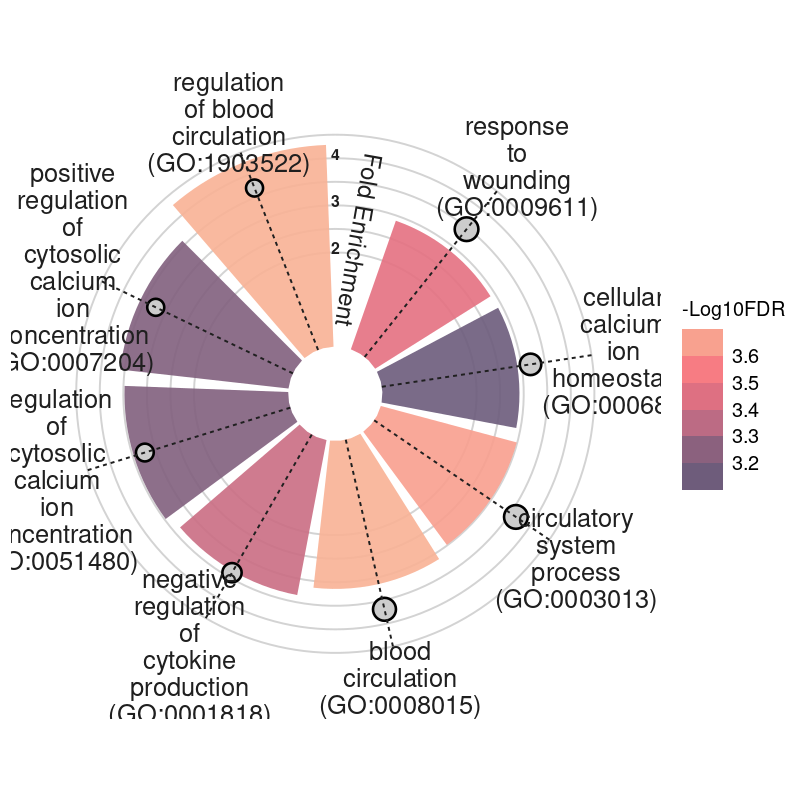

Saving 6.67 x 6.67 in image


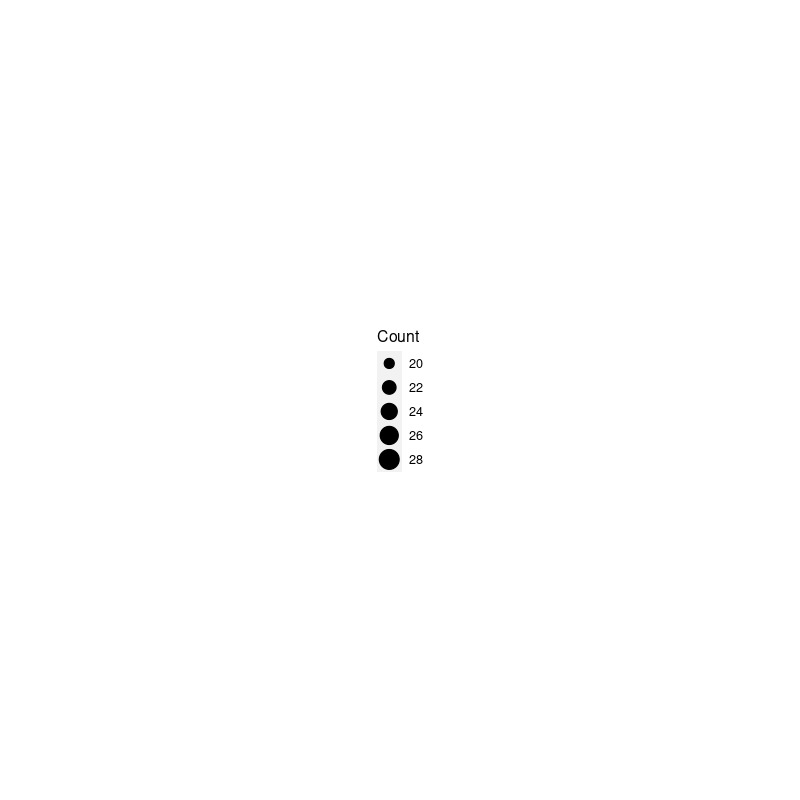

In [70]:
library(dplyr)
library(ggplot2)
library(stringr)

go <- go_all[go_all$ONTOLOGY == 'BP'] ## select BP
go <- go[1:10,] ## select top 10

li_gr = c()
li_br = c()
for (x in go$GeneRatio) {
  li_gr <- append(li_gr, (eval(parse(text=x))) )
}

for (x in go$BgRatio) {
  li_br <- append(li_br, (eval(parse(text=x))) )
}
tmp <- data.frame(go)
tmp$FE <- li_gr/li_br ## Fold enrichment
tmp$log10adjpval <- -log10(tmp$p.adjust)
tmp$rankFDR <- c(seq(1, nrow(tmp)))
tmp <- tmp[order( -tmp$FE),]
tmp$rankFE <- seq(1, nrow(tmp))
tmp$rank <- (tmp$rankFDR + tmp$rankFE)/2
tmp <- tmp[order(-tmp$log10adjpval),]
# tmp[order( tmp$rankFE),]
go <- tmp[order( tmp$rankFE),]

# go

EC <- data.frame(Category  = go$ONTOLOGY,
                 ID = go$ID, 
                 Term =  go$Description,
                 Genes =  gsub("/",", ", go$geneID),
                adj_pval =  go$p.adjust,
                 fold.enrichment = go$FE,
                count = go$Count)

EC['-Log10FDR'] = -log10(EC$adj_pval)

plot_df <- EC[1:8,]
plot_df['region'] <- paste(plot_df$Term,'(',plot_df$ID,')') #plot_df['Term'] + plot_df['ID']
plot_df['region'] <- gsub("\\( ", "(", plot_df$region )
plot_df['region'] <- gsub(" \\)", ")", plot_df$region )
plot_df['fold.enrichment'] <- plot_df['fold.enrichment']
plot_df['Log10FDR'] <- -log10(plot_df['adj_pval'])
plot_df['Count'] <- plot_df['count']
plot_df <- plot_df[c('region','fold.enrichment','Count','Log10FDR')]
plot_df

options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 100) 

plt <- ggplot(plot_df) +
  # Make custom panel grid
  geom_hline(
    aes(yintercept = y), 
    data.frame(y = c(2,2.5,3,3.5,4,4.5) ),
    color = "lightgrey"
  ) + 
  # Add bars to represent the cumulative track lengths
  # str_wrap(region, 5) wraps the text so each line has at most 5 characters
  # (but it doesn't break long words!)
  geom_col(
    aes(
      x = reorder(str_wrap(region, 10), fold.enrichment),
      y = fold.enrichment,
      fill = Log10FDR
    ),
    position = "dodge2",
    show.legend = TRUE,
     alpha = .9
  ) +
  
  # #Add dots to represent the mean gain
  geom_point(color='black',  fill = 'grey80',stroke = 1,pch = 21,
    aes(
        
      x = reorder(str_wrap(region, 10), fold.enrichment ),
      y = Log10FDR
    ),
      
    #size = 3,
      size = plot_df$Count/4,
    # color = "gray12",
     
  ) +
  
  # Lollipop shaft for mean gain per region
  geom_segment(
    aes(
      x = reorder(str_wrap(region, 10), fold.enrichment),
      y = 0,
      xend = reorder(str_wrap(region, 10), fold.enrichment),
      yend = 4.5
    ),
    linetype = "dashed",
    color = "gray12"
  ) + 
  # Make the guide for the fill discrete
guides(
    fill = guide_colorsteps(
      # barwidth = 8, barheight = 2, title.position = "top", title.hjust = .5
         barwidth = 2, barheight = 8, title.position = "top", title.hjust = .5
    )
  )+
  # Make it circular!
  coord_polar()+ 
theme(
    # Remove axis ticks and text
    axis.title = element_blank(),
    axis.ticks = element_blank(),
    axis.text.y = element_blank(),
    # Use gray text for the region names
    axis.text.x = element_text(color = "gray12", size = 18),
    # Move the legend to the bottom
    legend.position = "right",#"bottom",
    panel.background = element_rect(fill = "white", color = "white"),
    panel.grid = element_blank(),
    panel.grid.major.x = element_blank(),
  legend.title=element_text(size=14),
  legend.text=element_text(size=14)
  ) 

p <- plt +
  annotate(
    x = 0.3, 
    y = 2.3,
    label = "Fold Enrichment",
    geom = "text",
    angle = -100,
    color = "gray12",
    size = 6,
    # family = "Bell MT"
  ) +

  # Annotate custom scale inside plot
  annotate(
    x = 0.1, 
    y = 3.1, 
    label = "3", 
    geom = "text", 
    color = "gray12", 
    # family = "Bell MT",
      fontface = "bold"
  ) +
  annotate(
    x = 0.1, 
    y = 2.1, 
    label = "2", 
    geom = "text", 
    color = "gray12", 
    # family = "Bell MT",
      fontface = "bold"
  ) +
    annotate(
        x = 0.1, 
        y = 4.1, 
        label = "4", 
        geom = "text", 
        color = "gray12", 
        # family = "Bell MT",
        fontface = "bold"
      ) +


    scale_y_continuous(
        limits = c(-1, 4.5),
        expand = c(0, 0),
        breaks = c(2.5, 3, 3.5, 4, 4.5)
      ) +
# #   #New fill and legend title for number of tracks per region
  scale_fill_gradientn(
    "-Log10FDR",
     colours = c( "#6C5B7B","#C06C84","#F67280","#F8B195")
  ) +

theme(
    # Remove axis ticks and text
    axis.title = element_blank(),
    axis.ticks = element_blank(),
    axis.text.y = element_blank(),
    # Use gray text for the region names
    axis.text.x = element_text(color = "gray12", size = 18),
    # Move the legend to the bottom
    legend.position = "right",#"bottom",
    panel.background = element_rect(fill = "white", color = "white"),
    panel.grid = element_blank(),
    panel.grid.major.x = element_blank(),
  legend.title=element_text(size=14),
  legend.text=element_text(size=14)
  ) 


p

ggsave(
  'Figures/Fig3D.pdf',
  plot = p)


p <- ggplot(plot_df, aes(fold.enrichment, Log10FDR))
p <- p + geom_point(aes(size = Count))

library(cowplot)
my_legend <- get_legend(p)


library(ggpubr)
as_ggplot(my_legend)
ggsave(
  'Figures/Fig3D_legend.pdf',
  plot = last_plot())

## Repressed in Vit-D Stimulated (down-regulated) analysis

In [71]:
###########################
###### GO Analysis ########
###########################
de_genes_list <- fcvals_down #rbind(fcvals_up, fcvals_down)  
de_genes_list['mgi_symbol'] <- de_genes[ rownames(de_genes_list),]$ensembl_gene_id #hgnc_symbol #fData(eset)[rownames(de_genes_list),]$hgnc_symbol
genelist <- de_genes_list[,c('mgi_symbol','logFC', 'AveExpr', 't','P.Value', 'adj.P.Val', 'B')]
rownames(genelist) <- NULL
names(genelist)[1] <- "ID"
genelist <-  na.omit(genelist)
head(genelist)
dim(genelist)


de_genes_list <- fcvals_down #rbind(fcvals_up, fcvals_down)  
de_genes_list['mgi_symbol'] <- de_genes[ rownames(de_genes_list),]$mgi_symbol #hgnc_symbol #fData(eset)[rownames(de_genes_list),]$hgnc_symbol
genelist_symbol <- de_genes_list[,c('mgi_symbol','logFC', 'AveExpr', 't','P.Value', 'adj.P.Val', 'B')]
rownames(genelist_symbol) <- NULL
names(genelist_symbol)[1] <- "ID"
genelist_symbol <-  na.omit(genelist_symbol)
head(genelist_symbol)
dim(genelist_symbol)


,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000032014,-1.9716503,4.018960,-18.53658,1.473707e-16,1.754448e-13,27.88412
2,ENSMUSG00000025225,-0.9660870,7.564742,-16.96025,1.265654e-15,7.930319e-13,25.61887
3,ENSMUSG00000045573,-2.2106600,4.938318,-16.89729,1.383951e-15,8.237970e-13,25.68389
4,ENSMUSG00000020395,-0.7881286,9.432535,-15.17980,1.774025e-14,7.039922e-12,22.86228
5,ENSMUSG00000022246,-2.0775690,5.522652,-14.66196,4.008162e-14,1.289653e-11,22.24370
6,ENSMUSG00000027004,-1.9790282,4.127853,-14.34817,6.641984e-14,1.797110e-11,21.84504


[1] 438   7

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Oaf,-1.9716503,4.018960,-18.53658,1.473707e-16,1.754448e-13,27.88412
2,Nfkb2,-0.9660870,7.564742,-16.96025,1.265654e-15,7.930319e-13,25.61887
3,Penk,-2.2106600,4.938318,-16.89729,1.383951e-15,8.237970e-13,25.68389
4,Itk,-0.7881286,9.432535,-15.17980,1.774025e-14,7.039922e-12,22.86228
5,Rai14,-2.0775690,5.522652,-14.66196,4.008162e-14,1.289653e-11,22.24370
6,Frzb,-1.9790282,4.127853,-14.34817,6.641984e-14,1.797110e-11,21.84504


[1] 438   7

In [72]:
###########################
###### GO Analysis ########
###########################
go_all <- enrichGO(genelist$ID, 
                   OrgDb = "org.Mm.eg.db", 
               keyType       = 'ENSEMBL', #'SYMBOL','ENTREZID',
                ont           = "all",
                pAdjustMethod = "BH",#"BH",
               pvalueCutoff  = 0.05,
               # qvalueCutoff  = 0.05,
              minGSSize = 10,
            maxGSSize = 250,
                  universe = annot[rownames(lcpm),'ensembl_gene_id'],#'entrezgene_id'], 
                  readable = TRUE
                  )


In [73]:
## BP
ego <- filter(go_all, ONTOLOGY == 'BP')
edox <- pairwise_termsim(ego)
edox <- mutate(edox, log10.p.adjust = -log10(as.numeric(p.adjust)))
dim(as.data.frame(edox))

file_name = paste(PAPER_DATA, 'Tab_S5_down_stim_bp.csv', sep = .Platform$file.sep)
write.csv(as.data.frame(edox), file_name, row.names=FALSE)


[1] 222  11

> *Circular barplot (control)* 

Saving 6.67 x 6.67 in image


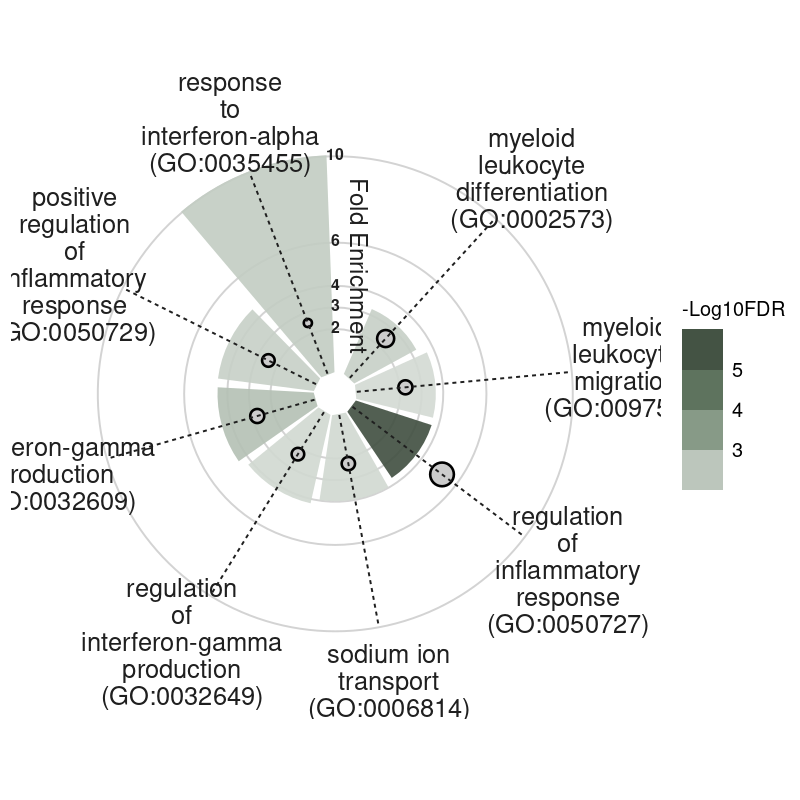

Saving 6.67 x 6.67 in image


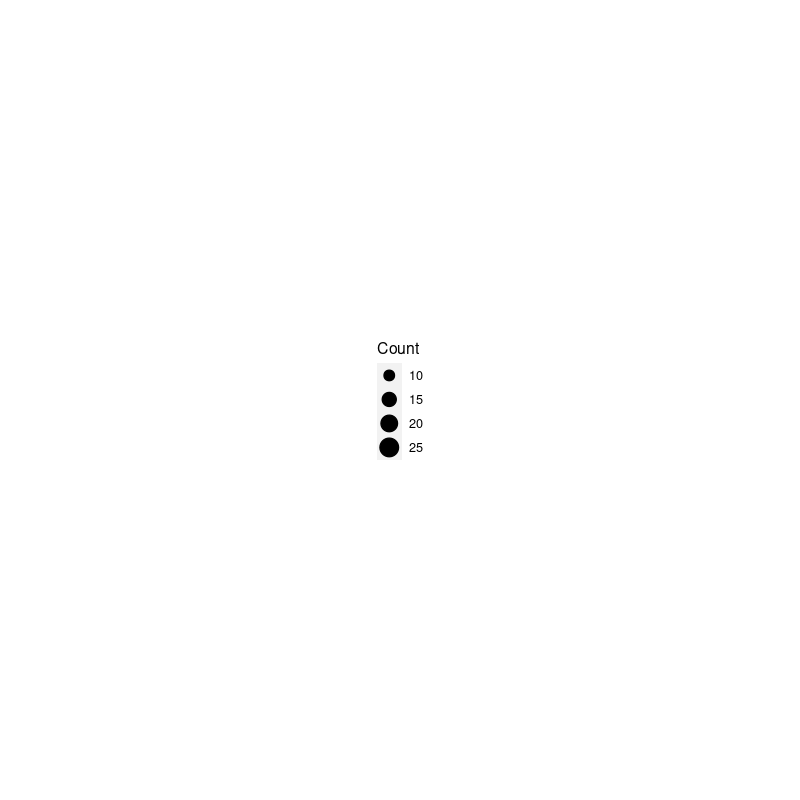

In [74]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 100) 

go <- go_all[1:10,]
li_gr = c()
li_br = c()
for (x in go$GeneRatio) {
  li_gr <- append(li_gr, (eval(parse(text=x))) )
}

for (x in go$BgRatio) {
  li_br <- append(li_br, (eval(parse(text=x))) )
}
tmp <- data.frame(go)
tmp$FE <- li_gr/li_br ## Fold enrichment
tmp$log10adjpval <- -log10(tmp$p.adjust)
tmp$rankFDR <- c(seq(1, nrow(tmp)))
tmp <- tmp[order( -tmp$FE),]
tmp$rankFE <- seq(1, nrow(tmp))
tmp$rank <- (tmp$rankFDR + tmp$rankFE)/2
tmp <- tmp[order(-tmp$log10adjpval),]
go <- tmp[order( tmp$rankFE),]

EC <- data.frame(
                 ID = go$ID, 
                 Term =  go$Description,
                Genes =  gsub("/",", ", go$geneID),
                adj_pval =  go$p.adjust,
                fold.enrichment = go$FE,
                count = go$Count)
EC$Category <- 'BP'


plot_df <- EC[1:8,]
plot_df['region'] <- paste(plot_df$Term,'(',plot_df$ID,')') #plot_df['Term'] + plot_df['ID']
plot_df['region'] <- gsub("\\( ", "(", plot_df$region )
plot_df['region'] <- gsub(" \\)", ")", plot_df$region )
plot_df['fold.enrichment'] <- plot_df['fold.enrichment']
plot_df['Log10FDR'] <- -log10(plot_df['adj_pval'])
plot_df['Count'] <- plot_df['count']
plot_df <- plot_df[c('region','fold.enrichment','Count','Log10FDR')]


plt <- ggplot(plot_df) +
  # Make custom panel grid
  geom_hline(
    aes(yintercept = y), 
    data.frame(y = c(2, 3, 4, 6, 10 ) ),#c(0:3) * 10),
    color = "lightgrey"
  ) + 
  # Add bars to represent the cumulative track lengths
  # str_wrap(region, 5) wraps the text so each line has at most 5 characters
  # (but it doesn't break long words!)
  geom_col(
    aes(
      x = reorder(str_wrap(region, 10), fold.enrichment),
      y = fold.enrichment,
      fill = Log10FDR
    ),
    position = "dodge2",
    show.legend = TRUE,
     alpha = .9
  ) +
  
  # #Add dots to represent the mean gain
  geom_point(color='black',  fill = 'grey80',stroke = 1,pch = 21,
    aes(
        
      x = reorder(str_wrap(region, 10), fold.enrichment ),
      y = Log10FDR
    ),
      
    #size = 3,
      size = plot_df$Count/4,
    # color = "gray12",
     
  ) +
  
  # Lollipop shaft for mean gain per region
  geom_segment(
    aes(
      x = reorder(str_wrap(region, 10), fold.enrichment),
      y = 0,
      xend = reorder(str_wrap(region, 10), fold.enrichment),
      yend = 10
    ),
    linetype = "dashed",
    color = "gray12"
  ) + 
  # Make the guide for the fill discrete
  guides(
    fill = guide_colorsteps(
      # barwidth = 8, barheight = 2, title.position = "top", title.hjust = .5
         barwidth = 2, barheight = 8, title.position = "top", title.hjust = .5
    )
  ) +
  # Make it circular!
  coord_polar()+
    theme(
    # Remove axis ticks and text
    axis.title = element_blank(),
    axis.ticks = element_blank(),
    axis.text.y = element_blank(),
    # Use gray text for the region names
    axis.text.x = element_text(color = "gray12", size = 18),
    # Move the legend to the bottom
    legend.position = "right",#"bottom",
    panel.background = element_rect(fill = "white", color = "white"),
    panel.grid = element_blank(),
    panel.grid.major.x = element_blank()
  ) 

p <- plt +
  annotate(
    x = 0.25, 
    y = 5,
    label = "Fold Enrichment",
    geom = "text",
    angle = -90,
    color = "gray12",
    size = 6,
    # family = "Bell MT"
  ) +

  # Annotate custom scale inside plot
  annotate(
    x = 0, 
    y = 2.1, 
    label = "2", 
    geom = "text", 
    color = "gray12", 
    # family = "Bell MT",
      fontface = "bold"
  ) +
  annotate(
    x = 0, 
    y = 3.1, 
    label = "3", 
    geom = "text", 
    color = "gray12", 
    # family = "Bell MT",
      fontface = "bold"
  ) +
    annotate(
        x = 0, 
        y = 4.1, 
        label = "4", 
        geom = "text", 
        color = "gray12", 
        # family = "Bell MT",
        fontface = "bold"
      ) +

    annotate(
        x = 0, 
        y = 6.1, 
        label = "6", 
        geom = "text", 
        color = "gray12", 
        # family = "Bell MT",
        fontface = "bold"
      ) +

    annotate(
        x = 0, 
        y = 10.1, 
        label = "10", 
        geom = "text", 
        color = "gray12", 
        # family = "Bell MT",
        fontface = "bold"
      ) +



    scale_y_continuous(
        limits = c(-1, 11),
        expand = c(0, 0),
        breaks = c(2, 3 , 4 , 6, 10)
      ) +
# #   #New fill and legend title for number of tracks per region
  scale_fill_gradientn(
    "-Log10FDR",
     colours = c("#d2d9d2", "#a6b4a6", "#798f79", "#607560", "#404e40" )#"#9ca897", '#5d6958', "#6b836b", "#72916a")#"#6C5B7B","#C06C84","#F67280","#F8B195")
  ) +

  # Scale y axis so bars don't start in the center
  theme(
    # Remove axis ticks and text
    axis.title = element_blank(),
    axis.ticks = element_blank(),
    axis.text.y = element_blank(),
    # Use gray text for the region names
    axis.text.x = element_text(color = "gray12", size = 18),
    # Move the legend to the bottom
    legend.position = "right",#"bottom",
    panel.background = element_rect(fill = "white", color = "white"),
    panel.grid = element_blank(),
    panel.grid.major.x = element_blank(),
  legend.title=element_text(size=14),
  legend.text=element_text(size=14)
  ) 

# pdf(file = "Figures/bp_up.pdf",  bg = "transparent", width = 8, height= 8)#, res = 50)   

# dev.off()
p


ggsave(
  'Figures/Fig3E.pdf',
  plot = p)


p <- ggplot(plot_df, aes(fold.enrichment, Log10FDR))
p <- p + geom_point(aes(size = Count))

library(cowplot)
my_legend <- get_legend(p)
library(ggpubr)
as_ggplot(my_legend)
ggsave(
  'Figures/Fig3E_legend.pdf',
  plot = last_plot())



## KEGG Pathway (Asthma)

In [75]:
library(pathview)
library(gage)
library(gageData)

data(kegg.sets.mm)
data(sigmet.idx.mm)
kegg.sets.mm = kegg.sets.mm[sigmet.idx.mm]
library("AnnotationDbi")
library("org.Mm.eg.db")
library(tibble)

## Load DE genes from Vit-D stimulated TH2 cells
res <- read.csv('Supplementary/Tab_S4.csv', row.names = 1 ) 


In [76]:
## https://www.r-bloggers.com/2015/12/tutorial-rna-seq-differential-expression-pathway-analysis-with-sailfish-deseq2-gage-and-pathview/
library("AnnotationDbi")
library("org.Mm.eg.db")
columns(org.Mm.eg.db)

library(pathview)
library(gage)
library(gageData)
data(kegg.sets.mm)
data(sigmet.idx.mm)
kegg.sets.mm = kegg.sets.mm[sigmet.idx.mm]
# head(kegg.sets.mm, 3)


res$symbol = mapIds(org.Mm.eg.db,
                     keys=row.names(res), 
                     column="SYMBOL",
                     keytype="ENSEMBL",
                     multiVals="first")
res$entrez = mapIds(org.Mm.eg.db,
                     keys=row.names(res), 
                     column="ENTREZID",
                     keytype="ENSEMBL",
                     multiVals="first")
res$name =   mapIds(org.Mm.eg.db,
                     keys=row.names(res), 
                     column="GENENAME",
                     keytype="ENSEMBL",
                     multiVals="first")
# head(res, 10)
# res <- topTable(fit2, coef='VitD_stim', number=Inf, sort.by='p', lfc = 0.585, p.value = 0.01)
# results <- res#[(res$adj.P.Val < 0.05) & (abs(res$logFC) > 0.58),]
# foldchanges =  results$logFC
# names(foldchanges) = results$entrezgene_id
# head(foldchanges)

#######################################
foldchanges =  res$logFC  # or any appropriate calculation based on your data
names(foldchanges) = res$entrez  # Ensure this matches the identifier used in your analysis

# Now 'foldchanges' is defined and can be used
keggres = gage(foldchanges, gsets=kegg.sets.mm, same.dir=TRUE)

#######################################



# Get the results
# keggres = gage(foldchanges, gsets=kegg.sets.mm, same.dir=TRUE)


keggrespathways = as_tibble(data.frame(id=rownames(keggres$greater), keggres$greater)) %>% 
  .$id %>% 
  as.character()

keggresids = substr(keggrespathways, start=1, stop=8)
# keggresids


options(repr.plot.width=20, repr.plot.height=10)
# pdf(file = "Figures/kegg.pdf",  bg = "transparent", width = 12, height= 8)#, res = 50)   

pid <- "mmu05310"
keggresids <- pid
# Define plotting function for applying later
plot_pathway = function(pid) pathview(gene.data=foldchanges, pathway.id=pid, species="mmu", new.signature=FALSE)
# plot multiple pathways (plots saved to disk and returns a throwaway list object)
tmp <- sapply(keggresids, function(pid) pathview(gene.data=foldchanges*100, pathway.id=pid, species="mmu",
                                                
                                                high = list(gene = '#fbb19f', cpd ="blue"),
                                                low = list(gene = '#c3d2bd', cpd ="yellow"),
                                                mid = list(gene = "gray88", cpd ="yellow"),
                                                 kegg.native = T

                                               ))

# keggview.graph(plot.data.gene = tmp['plot.data.gene',], plot.data.cpd = tmp['plot.data.cpd',]
# out.suffix = "pathview", pdf.size = c(7, 7))
# dev.off()             
                                      

[1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GENETYPE"     "GO"           "GOALL"        "IPI"          "MGI"         
[16] "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"         "PMID"        
[21] "PROSITE"      "REFSEQ"       "SYMBOL"       "UNIPROT"

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

Info: Working in directory /udd/revfa/VDAART/Vit_D_Modulation_Channing/mouse_Th2_cells

Info: Writing image file mmu05310.pathview.png

